In [1]:
import gym
import ptan
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
class PGN(nn.Module):
    def __init__(self,input_size, action_size, hidden_size = 128):
        super(PGN, self).__init__()
    
        self.net = nn.Sequential(
         nn.Linear(input_size, hidden_size),
         nn.ReLU(),
         nn.Linear(hidden_size, action_size)
        )
    
    def forward(self, x):
        return self.net(x)

In [23]:
GAMMA = 0.99
BATCH_SIZE = 8
LEARNING_RATE = 0.001
ENTROPY_BETA = 0.01
ROLLOUT_LENGTH = 10

In [54]:
env = gym.make('CartPole-v0')

net = PGN(env.observation_space.shape[0], env.action_space.n, hidden_size = 128)

agent = ptan.agent.PolicyAgent(net, preprocessor=ptan.agent.float32_preprocessor, apply_softmax=True)

exp_buffer = ptan.experience.ExperienceSourceFirstLast(env, agent, gamma=GAMMA, steps_count = ROLLOUT_LENGTH)

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

reward_sum = 0.0
done_episodes = 0
xp_cntr = 0

batch_states, batch_actions, batch_scales = [],[],[]
total_rewards = []

kl_history = []
baseline_history = []
entropy_history = []
policyloss_history = []
gradmax_history = []
gradl2_history = []

for step_idx, exp in enumerate(exp_buffer):
    xp_cntr += 1
    
    reward_sum += exp.reward
    baseline = reward_sum/(step_idx + 1)
    
    batch_states.append(exp.state)
    batch_actions.append(int(exp.action))
    batch_scales.append(exp.reward - baseline)
    
    # handle new rewards
    new_rewards = exp_buffer.pop_total_rewards()
    if new_rewards:
        done_episodes += 1
        reward = new_rewards[0]
        total_rewards.append(reward)
        mean_rewards = float(np.mean(total_rewards[-100:]))
        if done_episodes % 30 == 0:
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d" %(step_idx, reward, mean_rewards, done_episodes))

            
        if mean_rewards > 195:
            print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
            break

    if len(batch_states) < BATCH_SIZE:
        continue
        
    optimizer.zero_grad()
    batch_states_v = torch.FloatTensor(batch_states)
    batch_actions_t = torch.LongTensor(batch_actions)
    batch_scales_v = torch.FloatTensor(batch_scales)
    
    # PG loss
    logits_v = net(batch_states_v)
    log_prob_v = F.log_softmax(logits_v,dim=1)
    log_prob_actions_v = batch_scales_v * log_prob_v[range(len(batch_states)),batch_actions_t]
    loss_policy_v = -log_prob_actions_v.mean()
    
    # entropy regularizer  -\sum_{a_t,s_t} pi(a_t|s_t) log[ pi(a_t|s_t) ] >= 0
    prob_v = F.softmax(logits_v,dim=1)
    entropy_v = -(prob_v * log_prob_v).sum(dim=1) # sum over a_t
    loss_entropy_v = ENTROPY_BETA*entropy_v.mean() # sum over s_t
    loss_v = loss_policy_v - loss_entropy_v # the negative on the entropy is to encourage the entropy 
                                            # to be large in th eminimization of the function
    
    loss_v.backward()
    optimizer.step()
    
    
     # compute training statistics
    if (xp_cntr % 100 == 0):
        # Compute the KL divergence between the old policy and new updated on given the new weights
        # make sure no MAJOR changes occur between steps on the policy, we want a smooth transition
        # or else our optimization will never converge
        new_logits_v = net(batch_states_v) # new weights computation
        new_prob_v = F.softmax(new_logits_v, dim=1)
        kl_div_v = -((new_prob_v/prob_v).log() * prob_v).sum(dim=1).mean()
        
        kl_history.append(kl_div_v.item())
    
        grad_max = 0.0
        grad_means = 0.0
        grad_count = 0
        for p in net.parameters():
            grad_max = max(grad_max, p.grad.abs().max().item())
            grad_means += (p.grad**2).mean().sqrt().item()
            grad_count +=1
    
    
        baseline_history.append(baseline)
        entropy_history.append(loss_entropy_v.item())
        policyloss_history.append(loss_policy_v.item())
        gradmax_history.append(grad_max)
        gradl2_history.append(grad_means/grad_count)
    
    batch_states.clear()
    batch_actions.clear()
    batch_scales.clear()

777: reward:  40.00, mean_100:  24.93, episodes: 30
2041: reward:  33.00, mean_100:  33.03, episodes: 60
3723: reward:  54.00, mean_100:  40.38, episodes: 90
5916: reward: 106.00, mean_100:  53.52, episodes: 120
10457: reward:  62.00, mean_100:  87.61, episodes: 150
15387: reward: 146.00, mean_100: 120.32, episodes: 180
20953: reward: 200.00, mean_100: 158.04, episodes: 210
26309: reward: 181.00, mean_100: 172.85, episodes: 240
30314: reward: 126.00, mean_100: 164.06, episodes: 270


KeyboardInterrupt: 

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

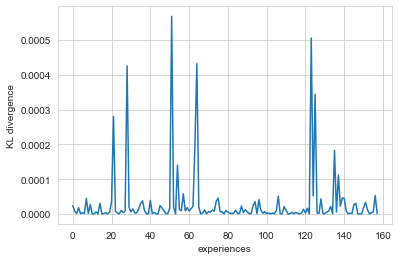

In [55]:
plt.plot(kl_history)
plt.xlabel('experiences')
plt.ylabel('KL divergence')
plt.show()

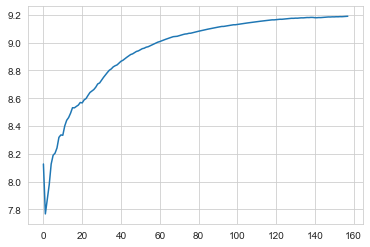

In [57]:
plt.plot(baseline_history)

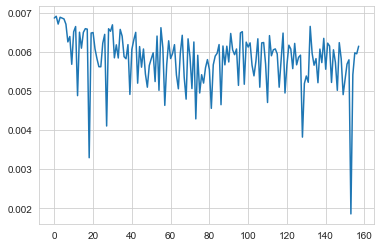

In [58]:
plt.plot(entropy_history)

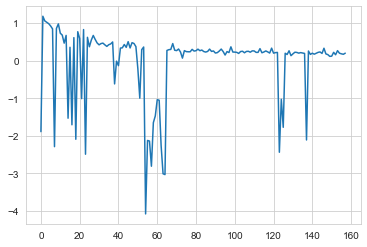

In [59]:
plt.plot(policyloss_history)

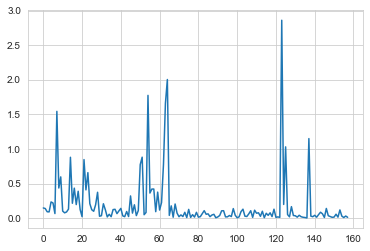

In [60]:
plt.plot(gradmax_history)

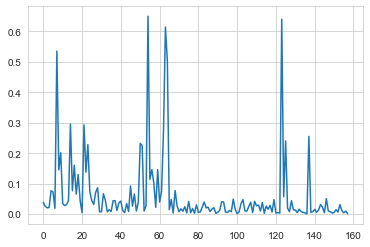

In [61]:
plt.plot(gradl2_history)